# 라이브러리

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
!pip install soynlp
!set -x \
&& pip install konlpy \
# && curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x
!pip install wordcloud
!pip install pyLDAvis==2.1.2
!pip install pmdarima

+ pip install konlpy


In [96]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 12, 12   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = r"/content/drive/MyDrive/python/16. Time Series analysis/주식/삼프로/NanumBarunGothic.ttf"
font = fm.FontProperties(fname=fontpath, size=14)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [97]:
import numpy as np
import pandas as pd

from wordcloud import WordCloud
from IPython.display import Image

from collections import Counter

# 경고문 무시
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk import word_tokenize, bigrams, ConditionalFreqDist
from nltk.util import ngrams
from nltk.probability import ConditionalProbDist, MLEProbDist
from konlpy.tag import Okt, Hannanum, Kkma, Komoran, Mecab
import soynlp
from soynlp.noun import LRNounExtractor_v2
from soynlp.tokenizer import LTokenizer

from gensim import corpora
from gensim.models import LsiModel, LdaModel, Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# 파일 합치기
import glob
import sys
import os

# 기타
import re
import requests
import json
import time
from google.colab import drive
from tqdm import notebook

# 0 전처리

## 데이터 로드
- https://entertain.naver.com/now?date=2021-12-01&page=1#sid=106&date=2021-12-31&page=205

In [5]:
df = pd.read_csv(r'/content/drive/MyDrive/python/16. Time Series analysis/주식/삼프로/유튜브_삼프로.csv', index_col=0)

In [6]:
df = df.loc[:,['date','title','text','views']]

df['date']=pd.to_datetime(df['date'], errors='coerce', format='%Y-%m-%d')
df.sort_values(by=['date'], inplace=True)

In [7]:
df = df[(df['date'] >= '2021-01-01') & (df['date'] <= '2021-12-31')]

In [8]:
# 달 분리
df.insert(loc=1,column='month',value=df['date'].dt.month)

print(len(df.date.unique()))
print(len(df.month.unique()))

231
12


In [9]:
# df[df.date.duplicated()]
df.drop_duplicates(['date'], keep='first', inplace=True)

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
df.groupby('month').count()

,date,title,text,views
month,,,,
1,20,20,20,20
2,17,17,17,17
3,22,22,22,22
4,22,22,22,22
5,19,19,19,19
6,22,22,22,22
7,22,22,22,22
8,21,21,21,21
9,8,8,8,8


In [12]:
df

,date,month,title,text,views
0,2021-01-04,1,3시간 특별 생방송.. '2021년 시장 대응 전략'을 말한다!_오늘아침 page2...,아 으 으 으 으 으 으 으 으 으 5 [음악] 으 으 [음악] 어 실이 시오 저는...,674755
1,2021-01-05,1,"2021년 스마트폰 성장 예상치와 업체들의 기회요인은_오늘아침 page2_김록호, ...",아 222 222 으 음 으 음 으 으 으 으 으 [음악] [음악] 실이 시오 저는...,242406
2,2021-01-06,1,연준의 통화정책 기조.. 글로벌 채권시장의 방향은 어떻게 될까_오늘아침 page2_...,아 으 a 으 으 으 으 으 으 또 실이 줘 저는 키도 작고 월급도 잡고 그냥 다 ...,198460
3,2021-01-07,1,"버블 금리 인플레이션 2021년 경제 포인트는_오늘아침 page2_박종훈, 이항영,...",아 으 re 아 으 na 으 으 으 으 으 으 으 으 으 으 으 으 에 대한민국 오...,294018
4,2021-01-08,1,코스피 3천 시대 진입.. 더 나은 수익을 위한 우리의 투자 방향은_오늘아침 pag...,아 으 르 으 아 으 으 으 으 으 으 으 으 으 으 으 [음악] 실이 시오 저는 ...,250617
...,...,...,...,...,...
226,2021-12-24,12,[아침 라이브] 수소화물차 운행 개시…_2030년 1만대 목표_21.12.24_박병...,아 으 으 으 으 [음악] [음악] 으 으 으 으 빨간색 옷을 많이 슛이 거든요 근...,295130
227,2021-12-27,12,[아침 라이브] 오미크론 확산에 CES 빨간불…구글·메타·MS 불참_21.12.27...,으 아 으 으 [음악] 으 으 [음악] [음악] 아침의 시작을 알리는 글로벌 주식 ...,342416
228,2021-12-28,12,여의도 차인표의 키워드로 보는 2022년 시장 전망!_아침 라이브_21.12.28_...,으 으 으 으 으 [음악] 아침에 시장 날리는 글로벌 주식 날 v 월스트리트 뭐니 ...,332447
229,2021-12-29,12,교보증권이 바라보는 2022년 시장 투자 전략!_아침 라이브_21.12.29_박병창...,으 으 으 으 [음악] 으 으 아침의 시작을 알리는 그걸 주실 ry 스트리트 본인 ...,317875


In [13]:
df.isna().sum()

date     0
month    0
title    0
text     0
views    0
dtype: int64

In [14]:
df.shape

(231, 5)

In [15]:
df.info

<bound method DataFrame.info of           date  ...   views
0   2021-01-04  ...  674755
1   2021-01-05  ...  242406
2   2021-01-06  ...  198460
3   2021-01-07  ...  294018
4   2021-01-08  ...  250617
..         ...  ...     ...
226 2021-12-24  ...  295130
227 2021-12-27  ...  342416
228 2021-12-28  ...  332447
229 2021-12-29  ...  317875
230 2021-12-30  ...  324028

[231 rows x 5 columns]>

## 단어 추출
- https://github.com/lovit/soynlp

In [16]:
df['text'] = df['text'].str.replace("[^0-9a-zA-Zㄱ-ㅣ가-힣 ]"," ")

In [17]:
# 형태소 분석기
# t1 = Okt()
# t2 = Hannanum()
# t3 = Kkma()
t4 = Komoran()

# noun_extractor = LRNounExtractor_v2()
# nouns = noun_extractor.train_extract(list(df['title']))
# noun_scores = {noun:score.score for noun, score in nouns.items()}
# t5 = LTokenizer(scores=noun_scores)

# t6 = Mecab()

In [18]:
# df['okt_noun'] = df['text'].apply(lambda x : t1.nouns(x))   # 성능 떨어짐
# df['hannanum_noun'] = df['text'].apply(lambda x : t2.nouns(x))   # 공백
# df['kkma_noun'] = df['text'].apply(lambda x : t3.nouns(x))   # 성능 떨어짐
df['noun'] = df['text'].apply(lambda x : t4.nouns(x))   # komoran_noun
# df['soynlp_noun'] = df['text'].apply(lambda x : t5.tokenize(x))   # 성능 떨어짐
# df['mecab_noun'] = df['text'].apply(lambda x : t6.nouns(x))   # 설치 불가

KeyboardInterrupt: ignored

## Komoran 추출 데이터 로드
- https://entertain.naver.com/now?date=2021-12-01&page=1#sid=106&date=2021-12-31&page=205

In [98]:
df = pd.read_csv(r'/content/drive/MyDrive/python/16. Time Series analysis/주식/삼프로/삼프로_komoran.csv', index_col=0)

In [99]:
df['date']=pd.to_datetime(df['date'], errors='coerce', format='%Y-%m-%d')
df.sort_values(by=['date'], inplace=True)

In [100]:
def change_list(x) :
  x = x.replace('[','')
  x = x.replace(']','')
  x = x.replace("'",'')
  x = x.replace(' ','')
  x = x.split(',')
  return x

In [101]:
df['noun'] = df['noun'].apply(lambda x : change_list(x))

In [102]:
df

,date,month,title,text,views,noun
0,2021-01-04,1,3시간 특별 생방송.. '2021년 시장 대응 전략'을 말한다!_오늘아침 page2...,아 으 으 으 으 으 으 으 으 으 5 음악 으 으 음악 어 실이 시오 저는...,674755,"[키, 월급, 결혼, 측, 영어, 배우자, 스마트, 방법, 스마트폰, 검색, 성원,..."
1,2021-01-05,1,"2021년 스마트폰 성장 예상치와 업체들의 기회요인은_오늘아침 page2_김록호, ...",아 222 222 으 음 으 음 으 으 으 으 으 음악 음악 실이 시오 저는...,242406,"[키, 월급, 결혼, 칩, 겨울, 배우자, 스마트, 방법, 스마트폰, 검색, 성원,..."
2,2021-01-06,1,연준의 통화정책 기조.. 글로벌 채권시장의 방향은 어떻게 될까_오늘아침 page2_...,아 으 a 으 으 으 으 으 으 또 실이 줘 저는 키도 작고 월급도 잡고 그냥 다 ...,198460,"[키, 월급, 결혼, 보오, 여우, 배우자, 스마트, 방법, 스마트폰, 검색, 성원..."
3,2021-01-07,1,"버블 금리 인플레이션 2021년 경제 포인트는_오늘아침 page2_박종훈, 이항영,...",아 으 re 아 으 na 으 으 으 으 으 으 으 으 으 으 으 으 에 대한민국 오...,294018,"[대한민국, 캡틴, 활약, 지경, 결여, 대, 포, 양말, 덕분, 발바닥, 에너지,..."
4,2021-01-08,1,코스피 3천 시대 진입.. 더 나은 수익을 위한 우리의 투자 방향은_오늘아침 pag...,아 으 르 으 아 으 으 으 으 으 으 으 으 으 으 으 음악 실이 시오 저는 ...,250617,"[르, 키, 월급, 결혼, 영어, 배우자, 스마트, 방법, 스마트폰, 검색, 성원,..."
5,2021-01-11,1,지금의 주식 시장.. 왜 전문가들의 전망과 반대로 움직일까_오늘아침 page2_권순...,으 으 음악 ter 으 으 으 으 으 으 으 으 음악 음악 에 대한민국 ...,409851,"[대한민국, 공멸, 도색, 캡틴, 모집, 핵, 비교, 비결, 골대, 양말, 덕분, ..."
6,2021-01-12,1,"코스피의 가파른 랠리..최근 시장 흐름에 대한 판단은_오늘아침 page2_허재환, ...",아 으 박수 음악 으 으 으 으 으 으 으 으 음악 또 실이 시오 저는 ...,331619,"[키, 월급, 결혼, 여우, 배우자, 스마트, 방법, 스마트폰, 검색, 성원, 후기..."
7,2021-01-13,1,코로나19 이후 변화된 음식료 시장의 특징과 2021년 전망은_오늘아침 page2_...,아 222 222 으 아 으 으 으 으 으 으 으 5 음악 으 음악 철학 책...,289055,"[철학, 책, 보험약관, 확인, 가입, 가입, 보험, 중복, 보험, 인지, 기존, ..."
8,2021-01-14,1,국내 1등 애널리스트가 말하는 철강·비철금속 투자 전략!_오늘아침 page2_이종형...,222 222 음악 0 으 으 으 으 으 으 으 으 으 으 으 또 실이 시오 저...,535132,"[키, 월급, 결혼, 웨이, 우측, 여우, 배우자, 스마트, 방법, 스마트폰, 검색..."
9,2021-01-15,1,"메모리 반도체, 슈퍼 사이클 왔나 우리의 투자 전략은_오늘아침 page2_최영산, ...",아 으 222 으 으 으 으 으 으 으 으 으 으 으 음악 새벽 6시 반 아침 ...,523842,"[새벽, 반, 방송, 새벽, 시작, 하루, 스튜디오, 발걸음, 상태, 만남, 방송,..."


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 230
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    231 non-null    datetime64[ns]
 1   month   231 non-null    int64         
 2   title   231 non-null    object        
 3   text    231 non-null    object        
 4   views   231 non-null    int64         
 5   noun    231 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.6+ KB


## 단어 변경
- https://datascienceschool.net/03%20machine%20learning/03.01.04%20soynlp.html

In [104]:
def noun_replace(data) :
  data = data.replace('닉스','하이닉스')

  return data

In [105]:
df['noun'] = df['noun'].apply(lambda x : [word.upper() for word in x])

In [106]:
df['noun'] = df['noun'].apply(lambda x : [noun_replace(word) for word in x])

## 불용어(StopWords) 처리
- https://www.ranks.nl/stopwords/korean

In [107]:
# 파일 불러오기
stop_words = pd.read_csv(r"/content/drive/MyDrive/python/16. Time Series analysis/주식/삼프로/stop_words_3pro.txt", sep='\n', encoding='utf8', header=None)

# set으로 중복 제거 후 리스트로 변환
print(len(stop_words))
stop_words = list(set(stop_words[0]))
print(len(stop_words))

1303
1171


In [108]:
stop_words

['진짜로',
 '증권',
 '칠',
 '실시간',
 '해석',
 '까지 미치다',
 '개인',
 '등',
 '있는',
 '뒤따라',
 '살펴보고',
 '너',
 '예전',
 '대비',
 'page2_강동진',
 '뒤',
 '쾅쾅',
 '위에서 서술한바와같이',
 '하물며',
 '이천팔',
 '힘입어',
 '눈',
 '따지지 않다',
 '기억',
 '합니다',
 '다음으로',
 '어',
 '아무거나',
 '혼자',
 '놀라다',
 '나은',
 '이유만으로',
 '상황',
 '연이서',
 '붕붕',
 '주목해야',
 '아니면',
 '으로 인하여',
 '주',
 '어느것',
 '에 대해',
 '맛',
 '보고서',
 '연말',
 '알았어',
 '채권시장의',
 '새',
 '얼마든지',
 '좋아',
 '기차',
 'page2_주민우',
 '동시에',
 '어느곳',
 '오오야',
 '시작하여',
 '한',
 '공급',
 '마저',
 '요',
 '삐걱거리다',
 '김지산',
 '업체',
 '미국의',
 '하기는한데',
 '우리의',
 '반',
 '비록',
 '만약',
 '예하면',
 '에게',
 'page2',
 '고요',
 '말하자면',
 '저',
 '리',
 '준비',
 '잠깐',
 '그저',
 '요만한 것',
 '비로소',
 '게',
 '시키다',
 '퍽',
 '밖',
 'page2_김열매\t',
 '비걱거리다',
 '증시의',
 '어떤',
 '이러이러하다',
 '이유',
 '처음',
 '조',
 '삐걱',
 '투자자',
 '언제',
 '상품',
 '한켠으로는',
 '끼익',
 '일단',
 '하고있었다',
 '더군다나',
 '어이',
 '딩동',
 '거의',
 '개',
 '입장',
 '방향은_오늘아침',
 '매각되서',
 '계속되는',
 '원',
 '게우다',
 '송재경',
 '저희',
 '소생',
 '기',
 '가수',
 '같이',
 '임에 틀림없다',
 '업',
 '널',
 '옆사람',
 '이 되다',
 '실로',
 '우리',
 '하게하다',
 '2월',
 '

In [109]:
# df['okt_noun'] = df['okt_noun'].apply(lambda x : [word for word in x if word not in stop_words])
# df['hannanum_noun'] = df['hannanum_noun'].apply(lambda x : [word for word in x if word not in stop_words])   # 공백
# df['kkma_noun'] = df['kkma_noun'].apply(lambda x : [word for word in x if word not in stop_words])   # 성능 떨어짐
df['noun'] = df['noun'].apply(lambda x : [word for word in x if word not in stop_words]) 
# df['soynlp_noun'] = df['soynlp_noun'].apply(lambda x : [word for word in x if word not in stop_words])   # 성능 떨어짐
# df['mecab_noun'] = df['mecab_noun'].apply(lambda x : [word for word in x if word not in stop_words])   # 설치 불가

In [110]:
df.noun[0][0]

'키'

In [111]:
df.head(10)

,date,month,title,text,views,noun
0,2021-01-04,1,3시간 특별 생방송.. '2021년 시장 대응 전략'을 말한다!_오늘아침 page2...,아 으 으 으 으 으 으 으 으 으 5 음악 으 으 음악 어 실이 시오 저는...,674755,"[키, 월급, 결혼, 측, 영어, 배우자, 스마트, 방법, 스마트폰, 성원, 후기,..."
1,2021-01-05,1,"2021년 스마트폰 성장 예상치와 업체들의 기회요인은_오늘아침 page2_김록호, ...",아 222 222 으 음 으 음 으 으 으 으 으 음악 음악 실이 시오 저는...,242406,"[키, 월급, 결혼, 칩, 겨울, 배우자, 스마트, 방법, 스마트폰, 성원, 후기,..."
2,2021-01-06,1,연준의 통화정책 기조.. 글로벌 채권시장의 방향은 어떻게 될까_오늘아침 page2_...,아 으 a 으 으 으 으 으 으 또 실이 줘 저는 키도 작고 월급도 잡고 그냥 다 ...,198460,"[키, 월급, 결혼, 보오, 여우, 배우자, 스마트, 방법, 스마트폰, 성원, 후기..."
3,2021-01-07,1,"버블 금리 인플레이션 2021년 경제 포인트는_오늘아침 page2_박종훈, 이항영,...",아 으 re 아 으 na 으 으 으 으 으 으 으 으 으 으 으 으 에 대한민국 오...,294018,"[대한민국, 캡틴, 활약, 지경, 결여, 포, 양말, 덕분, 발바닥, 에너지, 손실..."
4,2021-01-08,1,코스피 3천 시대 진입.. 더 나은 수익을 위한 우리의 투자 방향은_오늘아침 pag...,아 으 르 으 아 으 으 으 으 으 으 으 으 으 으 으 음악 실이 시오 저는 ...,250617,"[르, 키, 월급, 결혼, 영어, 배우자, 스마트, 방법, 스마트폰, 성원, 후기,..."
5,2021-01-11,1,지금의 주식 시장.. 왜 전문가들의 전망과 반대로 움직일까_오늘아침 page2_권순...,으 으 음악 ter 으 으 으 으 으 으 으 으 음악 음악 에 대한민국 ...,409851,"[대한민국, 공멸, 도색, 캡틴, 모집, 핵, 비교, 비결, 골대, 양말, 덕분, ..."
6,2021-01-12,1,"코스피의 가파른 랠리..최근 시장 흐름에 대한 판단은_오늘아침 page2_허재환, ...",아 으 박수 음악 으 으 으 으 으 으 으 으 음악 또 실이 시오 저는 ...,331619,"[키, 월급, 결혼, 여우, 배우자, 스마트, 방법, 스마트폰, 성원, 후기, 대한..."
7,2021-01-13,1,코로나19 이후 변화된 음식료 시장의 특징과 2021년 전망은_오늘아침 page2_...,아 222 222 으 아 으 으 으 으 으 으 으 5 음악 으 음악 철학 책...,289055,"[철학, 책, 보험약관, 가입, 가입, 보험, 중복, 보험, 인지, 기존, 가입, ..."
8,2021-01-14,1,국내 1등 애널리스트가 말하는 철강·비철금속 투자 전략!_오늘아침 page2_이종형...,222 222 음악 0 으 으 으 으 으 으 으 으 으 으 으 또 실이 시오 저...,535132,"[키, 월급, 결혼, 웨이, 우측, 여우, 배우자, 스마트, 방법, 스마트폰, 성원..."
9,2021-01-15,1,"메모리 반도체, 슈퍼 사이클 왔나 우리의 투자 전략은_오늘아침 page2_최영산, ...",아 으 222 으 으 으 으 으 으 으 으 으 으 으 음악 새벽 6시 반 아침 ...,523842,"[새벽, 새벽, 스튜디오, 발걸음, 만남, 김동완, 내일, 향, 커피, 커피, 립,..."


In [112]:
# df.to_csv('삼프로_komoran.csv', encoding='utf-8')

## 말뭉치(corpus) 만들기

In [113]:
# 전체 corpus
nouns = []
for i in range(len(df)) :
  nouns.append(df['noun'][i])

corpus = [y for x in nouns for y in x]

print(len(corpus))

884759


In [114]:
# 월별 corpus
for i in range(1,13) :
  globals()['df_{}'.format(i)] = df[df.month == i]
  print(i, globals()['df_{}'.format(i)].shape, end=' ')
  a, b = globals()['df_{}'.format(i)].shape

  nouns = []
  for j in range(a) :
    nouns.append(globals()['df_{}'.format(i)]['noun'].iloc[j])

  globals()['corpus_{}'.format(i)] = [y for x in nouns for y in x]

  print(len(globals()['corpus_{}'.format(i)]))

1 (20, 6) 70796
2 (17, 6) 58679
3 (22, 6) 74449
4 (22, 6) 75955
5 (19, 6) 64949
6 (22, 6) 76031
7 (22, 6) 77905
8 (21, 6) 71191
9 (8, 6) 28056
10 (19, 6) 87258
11 (18, 6) 92309
12 (21, 6) 107181


# 1 전체 데이터 분석

## 1-1 단어 빈도 분석

In [115]:
# Counter
noun_count = Counter(corpus)

# 데이터 프레임으로
word_freq = pd.DataFrame(data=[noun_count.keys(), noun_count.values()])
word_freq = word_freq.T

# 컬럼명 변경
word_freq.columns = ['단어', '빈도수']

# 빈도수에 따라 내림차순
word_freq.sort_values(by='빈도수', ascending=False, inplace=True)

# 인덱스 
word_freq.reset_index(drop=True, inplace=True)

In [116]:
# 월별 word_freq
for i in range(1,13) :
  # Counter
  noun_count = Counter(globals()['corpus_{}'.format(i)])

  # 데이터 프레임으로
  globals()['word_freq_{}'.format(i)] = pd.DataFrame(data=[noun_count.keys(), noun_count.values()])
  globals()['word_freq_{}'.format(i)] = globals()['word_freq_{}'.format(i)].T

  # 컬럼명 변경
  globals()['word_freq_{}'.format(i)].columns = ['{}월 단어'.format(i), '{}월 빈도수'.format(i)]

  # 빈도수에 따라 내림차순
  globals()['word_freq_{}'.format(i)].sort_values(by='{}월 빈도수'.format(i), ascending=False, inplace=True)

  # 인덱스 
  globals()['word_freq_{}'.format(i)].reset_index(drop=True, inplace=True)

### 표

In [117]:
# 전체
pd.set_option('display.max_rows', 500)
word_freq[:500]

,단어,빈도수
0,차,4930
1,반도체,4270
2,금리,4250
3,실적,3597
4,삼성전자,2748
5,자동차,2201
6,기준,2067
7,삼성,2038
8,물가,1994
9,게임,1916


In [118]:
# 월별 top 20
word_freq_month = pd.DataFrame()
for i in range(1,13):
  word_freq_month = pd.concat([word_freq_month, globals()['word_freq_{}'.format(i)]], axis=1)

In [119]:
word_freq_month.iloc[:100,::2]

,1월 단어,2월 단어,3월 단어,4월 단어,5월 단어,6월 단어,7월 단어,8월 단어,9월 단어,10월 단어,11월 단어,12월 단어
0,차,차,금리,반도체,실적,차,실적,반도체,차,실적,차,차
1,삼성전자,금리,차,실적,반도체,반도체,차,삼성전자,수소,차,반도체,반도체
2,금리,반도체,반도체,차,차,금리,금리,차,금리,금리,게임,금리
3,반도체,실적,배터리,삼성전자,물가,물가,반도체,실적,반도체,테슬라,금리,삼성전자
4,삼성,애플,금,금리,공매도,자동차,카카오,게임,삼성전자,반도체,실적,기준
5,실적,현대차,네이버,삼성,자동차,삼성전자,배터리,금리,에너지,물가,테슬라,배당
6,자동차,자동차,채권,백신,삼성,실적,데이터,테이퍼링,고용,게임,삼성전자,책
7,애플,배터리,은행,자동차,금리,카카오,기준,삼성,삼성,자동차,애플,애플
8,조정,금,실적,회복,백신,네이버,물가,고용,소재,데이터,자동차,자동차
9,게임,채권,기준,기준,인플레이션,책,자동차,하이닉스,현대차,조정,배당,물가


### 수직막대

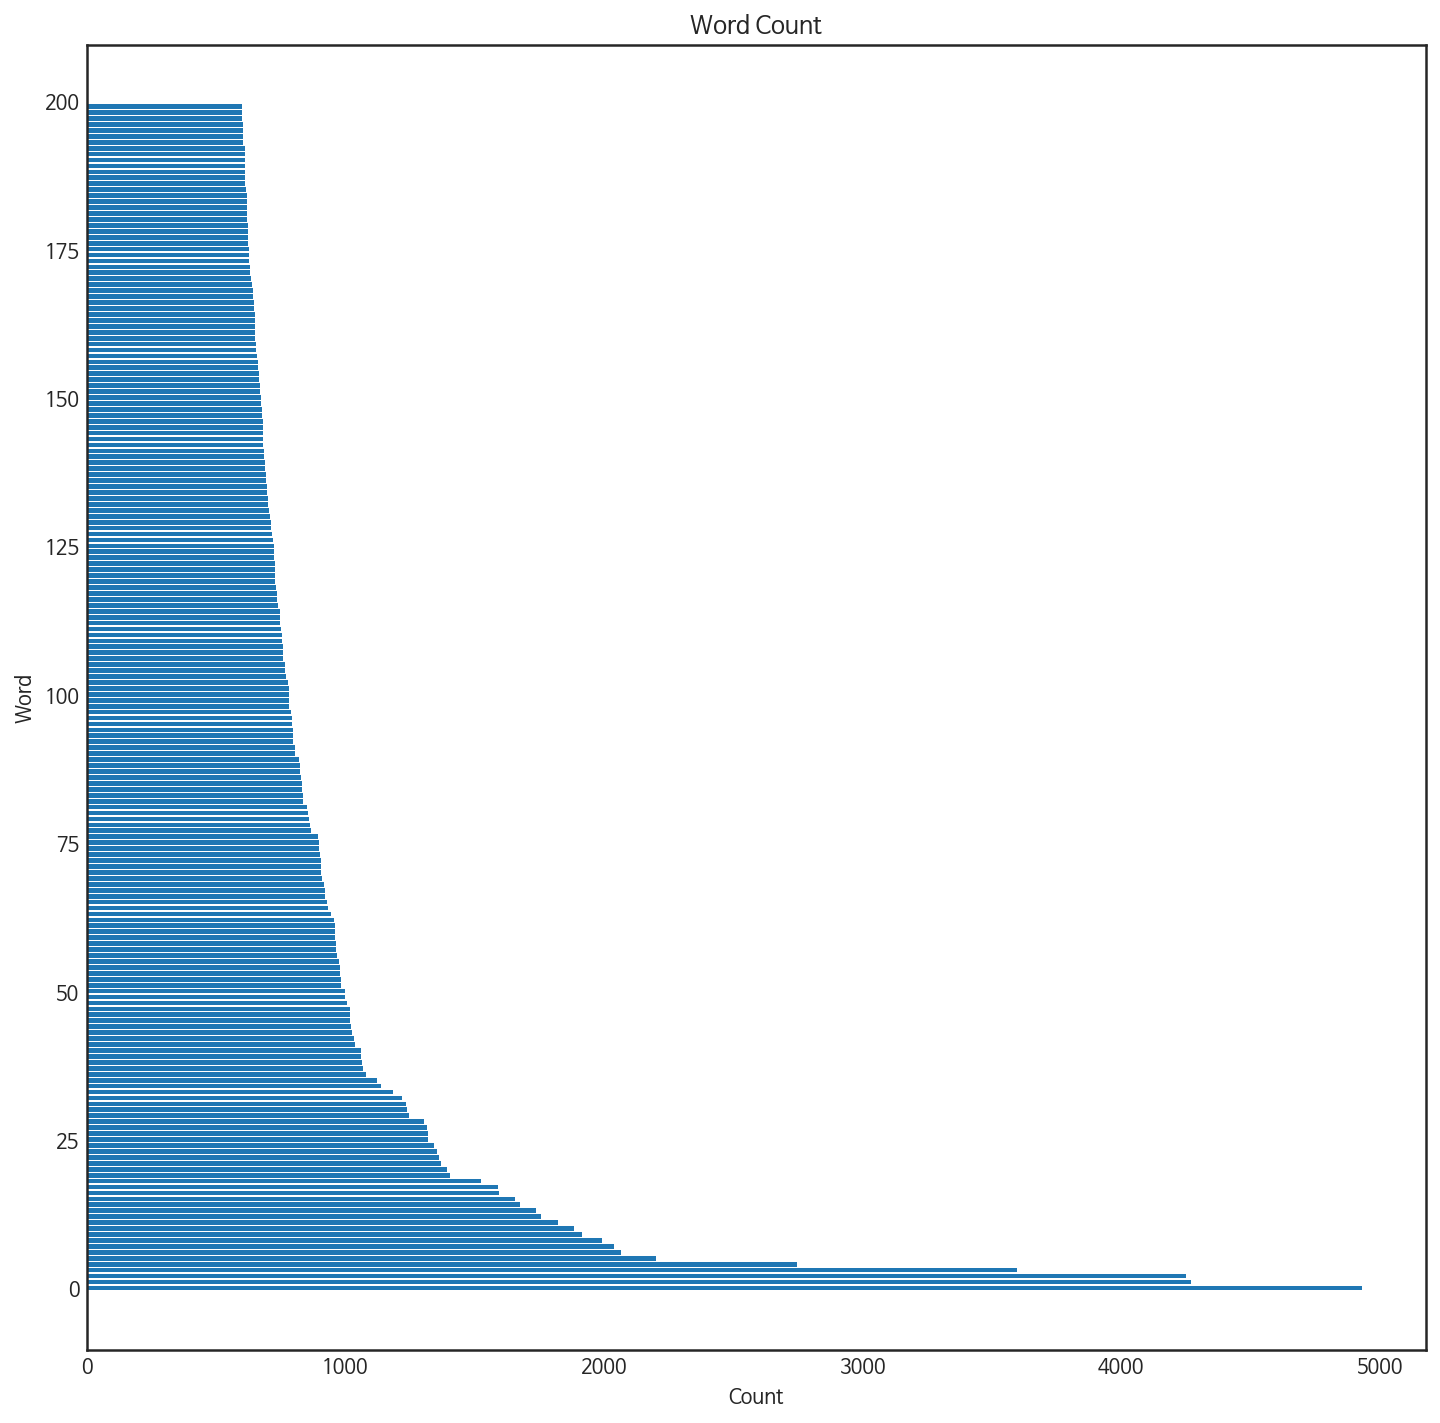

In [120]:
# top 200
word_freq_dic = dict(zip(word_freq['단어'][:200].tolist(), word_freq['빈도수'][:200].tolist()))

y_pos = np.arange(len(word_freq_dic))

plt.figure(figsize=(12,12))
plt.barh(y_pos, word_freq_dic.values())
plt.title('Word Count')
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

### 워드크라우드

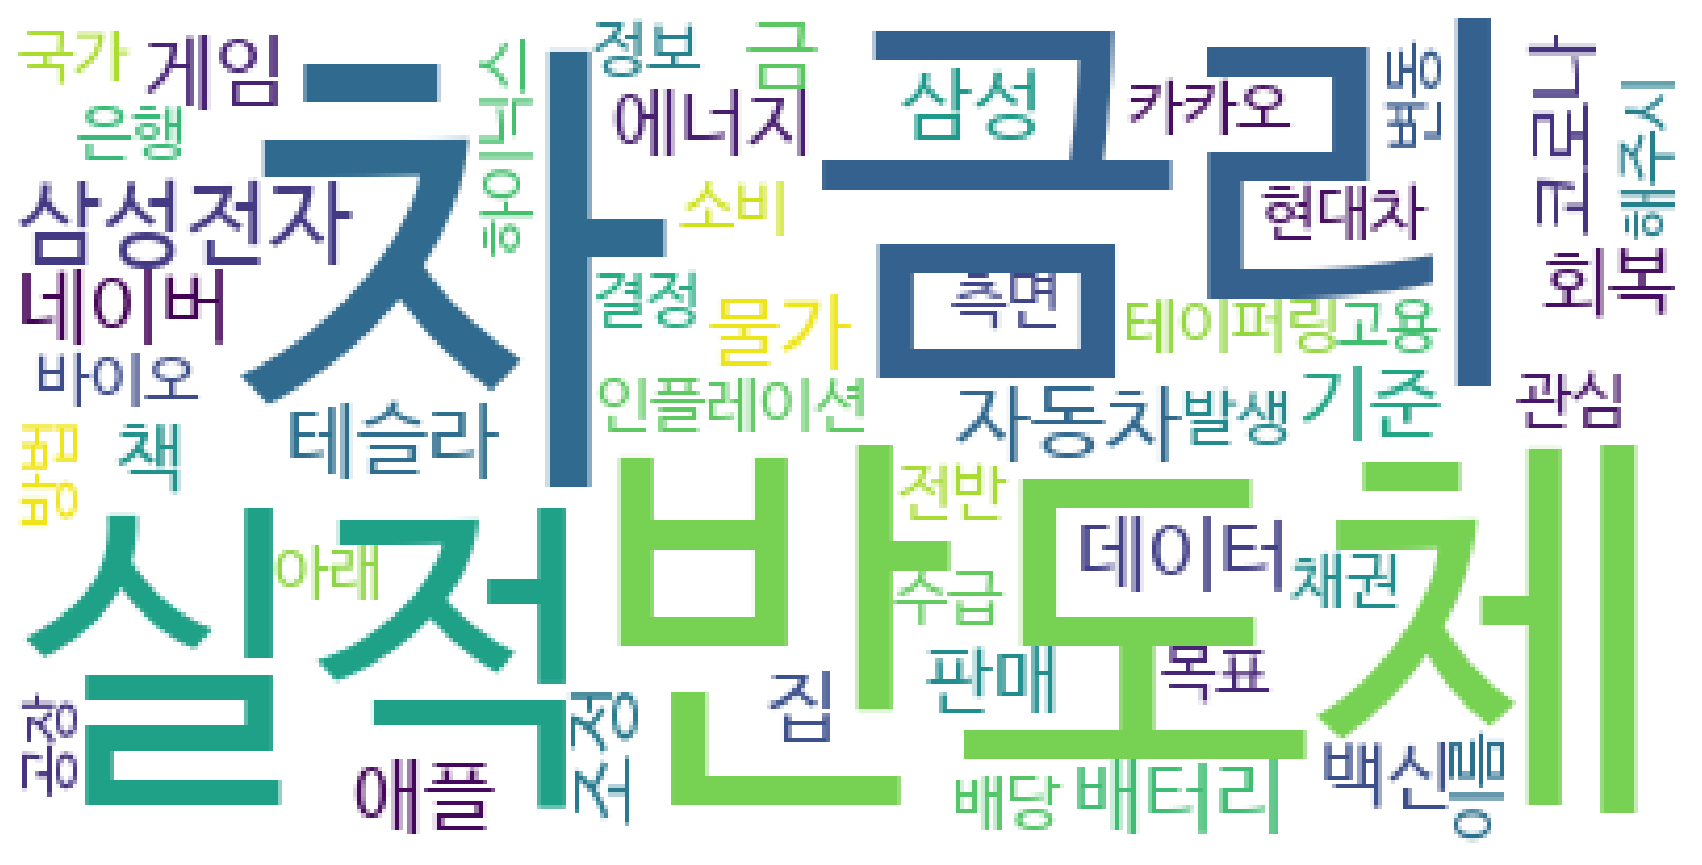

In [121]:
# top 50
word_freq_dic = dict(zip(word_freq['단어'][:50].tolist(), word_freq['빈도수'][:50].tolist()))

wc = WordCloud(background_color='white', font_path='/content/drive/MyDrive/3조_final_project/98_코딩파일/NanumBarunGothic.ttf')
wc.generate_from_frequencies(word_freq_dic)

figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

In [122]:
# # 저장
# cloud.to_file('word_freq_200.jpg')

## 1-2 TF-IDF (성능 떨어짐)

In [123]:
docs = df['noun'].apply(lambda x: ' '.join(x)).tolist()

# 모델
vect = TfidfVectorizer(max_features=1000, stop_words=stop_words)
tfvect = vect.fit_transform(docs)

# 데이터 프레임
word_tf = pd.DataFrame({
    '단어': vect.get_feature_names(),
    'TF-IDF': tfvect.sum(axis=0).flat
})

# TF-IDF에 따라 내림차순
word_tf.sort_values('TF-IDF', ascending=False, inplace=True)

# 인덱스 
word_tf.reset_index(drop=True, inplace=True)

In [124]:
for i in range(1,13) :
  docs = globals()['df_{}'.format(i)]['title'].tolist()

  # 모델
  tfvect = vect.fit_transform(docs)

  # 데이터 프레임으로
  globals()['word_tf_{}'.format(i)] = pd.DataFrame(data=[vect.get_feature_names(), tfvect.sum(axis=0).flat])
  globals()['word_tf_{}'.format(i)] = globals()['word_tf_{}'.format(i)].T

  # 컬럼명 변경
  globals()['word_tf_{}'.format(i)].columns = ['{}월 명사'.format(i), '{}월 TF-IDF'.format(i)]

  # TF-IDF에 따라 내림차순
  globals()['word_tf_{}'.format(i)].sort_values(by='{}월 TF-IDF'.format(i), ascending=False, inplace=True)

  # 인덱스 
  globals()['word_tf_{}'.format(i)].reset_index(drop=True, inplace=True)

In [125]:
# 전체
word_tf[:300]

,단어,TF-IDF
0,금리,30.763757
1,반도체,30.259244
2,실적,25.542212
3,삼성전자,19.342452
4,물가,15.995544
5,자동차,15.436469
6,배터리,14.758023
7,삼성,14.556701
8,기준,14.282283
9,게임,13.672864


In [126]:
# 월별 top 20
word_tf_month = pd.DataFrame()
for i in range(1,13):
  word_tf_month = pd.concat([word_tf_month, globals()['word_tf_{}'.format(i)]], axis=1)

In [127]:
word_tf_month.iloc[:100,::2]

,1월 명사,2월 명사,3월 명사,4월 명사,5월 명사,6월 명사,7월 명사,8월 명사,9월 명사,10월 명사,11월 명사,12월 명사
0,_오늘아침,2차전지,page2_유동원,전략은_오늘아침,김효진,김효진,라이브_박병창,라이브_박병창,라이브_박병창,라이브_박병창,라이브_21,라이브_21
1,스마트폰,인플레이션을,fomc,김효진,전략은_오늘아침,반도체,_오늘아침,라이브_이항영,주목받는,라이브_21,염승환_21,_아침
2,lg전자,수소,연준이,미래는_오늘아침,본부장이,cpi,라이브_김효진,라이브_김효진,라이브_이항영,전략은_오늘아침,라이브_박병창,2022년
3,통화정책,동맹,page2_한병화,센터장이,page2_유동원,page2_유지웅,하나금융투자가,반도체,친환경,김영익,사경인,박석중
4,규제,ipo,폭스바겐의,page2_김대준,_오늘아침,_오늘아침,page2_이재만,돌파구는_오늘아침,라이브_한병화,전망하는,박세익,이경수
5,2차,시장에,김효진,다가오는,실적,etf,라이브_송재경,삼성전자의,수소에너지,4분기,2022년,사경인
6,전지,급등하는,유동원,전망하는,반도체,산업의,투자사가,테마주의,라이브_김효진,힘들었던,김효진,겨울
7,음식료,유가,작년과는,반도체,파트장에게,page2_김선우,시장은_오늘아침,공시가,욕먹던,이후는,성공,김효진
8,구속,애플카,사뭇,page2_홍춘욱,듣는,시장은_오늘아침,신중한,정보,잭슨홀,라이브_박소연,_아침,구글
9,코로나19,부동산,본부장이,page2_김현용,메리츠,page2_송명섭,경제를,팔까_오늘아침,조익재,모멘텀은_오늘아침,2탄,29_박병창


## 1-3 토픽 모델링 (Topic Modeling)
- 토픽 모델링: 문서 집합에서 주제를 찾아내기 위한 기술

### 평가기준 (Measure)
1. Coherence (일관성) \
해당 토픽 모델의 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

  - 주의사항! \
  문서 집합의 Coherence 가 높아지면 monotonic 해지는 문제점이 생김. 마치 Bias-Variance tradeoff 처럼, 만약 coherence가 너무 높아지면 정보의 양이 줄어들게 되고, coherence가 너무 낮아지면 정보들이 일관성이 없어짐.

2. Perplexity (혼란도) \
Perlexity값이 작으면 토픽모델이 문서를 잘 반영된다고 할 수 있음. 그러나 Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님


* Recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. Optimizing for perplexity may not yield human interpretable topics. This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence. The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. \
 출처: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


In [ ]:
texts = np.array(df['noun'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus[1])

[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


### LSA
- 잠재 의미 분석(Latent Semantic Analysis) = 잠재 의미 인덱싱(Latent Semantic Indexing, LSI)
* 잠재 의미 분석(LSA)은 주로 문서 색인의 의미 검색에 사용
* LSA의 목표는 문서와 단어의 기반이 되는 잠재적인 토픽을 발견하는 것
* 잠재적인 토픽은 문서에 있는 단어들의 분포를 주도한다고 가정

* BoW에 기반한 DTM이나 TF-IDF는 기본적으로 단어의 빈도 수를 이용한 수치화 방법이기 때문에 단어의 의미를 고려하지 못한다는 단점이 있음

* LSA는 쉽고 빠르게 구현이 가능할 뿐만 아니라 단어의 잠재적인 의미를 이끌어낼 수 있어 문서의 유사도 계산 등에서 좋은 성능을 보여준다는 장점을 갖고 있음. 하지만 SVD의 특성상 이미 계산된 LSA에 새로운 데이터를 추가하여 계산하려고 하면 보통 처음부터 다시 계산해야 함. 즉, 새로운 정보에 대해 업데이트가 어려움. 이는 최근 LSA 대신 Word2Vec 등 단어의 의미를 벡터화할 수 있는 또 다른 방법론인 인공 신경망 기반의 방법론이 각광받는 이유임.

In [ ]:
lsi_model = LsiModel(corpus, num_topics=14, id2word=dictionary)
topics = lsi_model.print_topics()
topics

[(0,
  '0.956*"방탄소년단" + 0.113*"뷔" + 0.096*"지민" + 0.087*"콘서트" + 0.079*"정국" + 0.069*"빌보드" + 0.053*"2AM" + 0.051*"콜드플레이" + 0.039*"아미" + 0.038*"OST"'),
 (1,
  '0.749*"임영웅" + 0.281*"신사" + 0.272*"아가씨" + 0.199*"지현우" + 0.192*"이세희" + 0.089*"기부" + 0.084*"아이돌" + 0.080*"OST" + -0.077*"방탄소년단" + 0.074*"도망"'),
 (2,
  '-0.487*"신사" + -0.474*"아가씨" + 0.428*"임영웅" + -0.366*"지현우" + -0.349*"이세희" + -0.120*"박하나" + 0.062*"홍천기" + 0.056*"기부" + 0.055*"에스파" + 0.053*"아이돌"'),
 (3,
  '0.517*"김선호" + 0.294*"갯마을" + 0.291*"차차차" + 0.250*"옷소매" + 0.216*"이준호" + 0.212*"로맨스" + 0.206*"신민아" + -0.198*"임영웅" + 0.183*"이세영" + 0.135*"송혜교"'),
 (4,
  '0.499*"김선호" + -0.329*"옷소매" + -0.286*"이준호" + 0.275*"갯마을" + 0.272*"차차차" + -0.241*"이세영" + -0.193*"로맨스" + 0.192*"신민아" + -0.159*"송혜교" + -0.143*"지헤중"'),
 (5,
  '-0.611*"코로나" + -0.352*"확진" + -0.251*"블랙핑크" + -0.235*"유재석" + 0.183*"옷소매" + 0.160*"이준호" + -0.150*"리사" + -0.139*"스우파" + 0.138*"로맨스" + 0.134*"이세영"'),
 (6,
  '-0.684*"지리산" + -0.495*"전지현" + -0.410*"주지훈" + 0.148*"옷소매" + 0.133*"이준호" + 0.111*"이세영"

### LDA

- 잠재 디리클레 할당(Latent Dirichlet Allocation)
* 잠재 디레클레 할당 방법
  1. 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 w가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

  * $p(t|d)$ - 문서 d의 단어들 중 토픽 t에 해당하는 비율  

  * $p(w|t)$- 단어 w를 가지고 있는 모든 문서들 중  토픽 t가 할당된 비율

* LDA는 문서들은 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정. 데이터가 주어지면, LDA는 문서가 생성되던 과정을 역추적.

- LSA : DTM을 차원 축소 하여 축소 차원에서 근접 단어들을 토픽으로 묶는다.
- LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.

In [ ]:
# lda_model = LdaModel(corpus, num_topics=14, id2word=dictionary,          
#                      passes=1, decay=0.5, offset=1.0,                    
#                      update_every=1, alpha='symmetric', eta=None,         
#                      distributed=False, chunksize=2000,  eval_every=10, iterations=50,  
#                      gamma_threshold=0.001, minimum_probability=0.01, 
#                      random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None)

#### 최적화 (Optimization)
- LDA 공식 문서: https://radimrehurek.com/gensim/models/ldamodel.html
- LDA 설명 블로그: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/
- LDA 설명 블로그: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado

##### Topic 수 변화

In [ ]:
min_topics, max_topics = 20, 101
# coherences_score=[]
# perplexities_score=[] 

# for num_topics in range(min_topics, max_topics) :
#   time_before = time.time()
#   lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1)
#   print('num_topics "{}"'.format(num_topics))
 
#   cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary)

#   coherences_score.append(cm.get_coherence())
#   perplexities_score.append(lda_model.log_perplexity(corpus))

#   print("Cpherence : ", cm.get_coherence())    
#   print('Perplexity : ', lda_model.log_perplexity(corpus))
#   print('Time : ', (time.time() - time_before)/60)
#   print('='*30)

In [ ]:
# coherences_score = list(map(float, input().split(',')))

0.5606463403016078,  0.5800634686524877,  0.5770662568749336,  0.5710696893735225,  0.5740812716212229,  0.5627340543688025,  0.5604435651849898,  0.5624931739157856,  0.5724032834128098,  0.5729830860209748,  0.5744574044372843,  0.57335540115811,  0.5663557070220774,  0.5690522501204729,  0.5702020919942391,  0.577346591032555,  0.5753750291669582,  0.5818346531371396,  0.5658139554927297,  0.5742027444093347,  0.5757045869341131,  0.58270128272278,  0.5794656387811793,  0.5778669755474058,  0.5789591643426244,  0.5701820472273792,  0.5746937502117462,  0.5764215212770366,  0.5802698188703737,  0.5821574715504217,  0.5795574285482313,  0.5715690238671118,  0.5743739340365555,  0.5776264368031663,  0.5761269175500977,  0.5802466123213622,  0.5838016020961797,  0.5802691264341249,  0.5769246084316582,  0.5810963495218392,  0.5744788661603923,  0.5812050797760386,  0.583849978706933,  0.5801154577148778,  0.5824039453637039,  0.5821330288581824,  0.5796817318364914,  0.583220692266716, 

In [ ]:
# perplexities_score = list(map(float, input().split(',')))

-11.138551418474703,  -11.185985580347761,  -11.229936806212736,  -11.277834624812366,  -11.31506056552991,  -11.347456257266678,  -11.39251976272328,  -11.42812519464608,  -11.46981309970274,  -11.496336857022266,  -11.544888728040496,  -11.583839441885129,  -11.621011812490163,  -11.654811214730362,  -11.698398764704995,  -11.71722407704667,  -11.762174864039961,  -11.806289771846775,  -11.84487578680003,  -11.87454466910972,  -11.906589049512677,  -11.941287901978919,  -11.976084671779425,  -12.025021930844337,  -12.053690846162151,  -12.085945497405909,  -12.103651541532424,  -12.142301208064373,  -12.178514721491455,  -12.225943675692488,  -12.256013047430388,  -12.279330751038165,  -12.314744172458363,  -12.348347464983473,  -12.380718622358799,  -12.424205293230354,  -12.451167692481368,  -12.482932374641337,  -12.504617960725174,  -12.558740338799389,  -12.577630067844957,  -12.6101678929655,  -12.643601798383093,  -12.67266623122136,  -12.722273717665434,  -12.735669229865143,

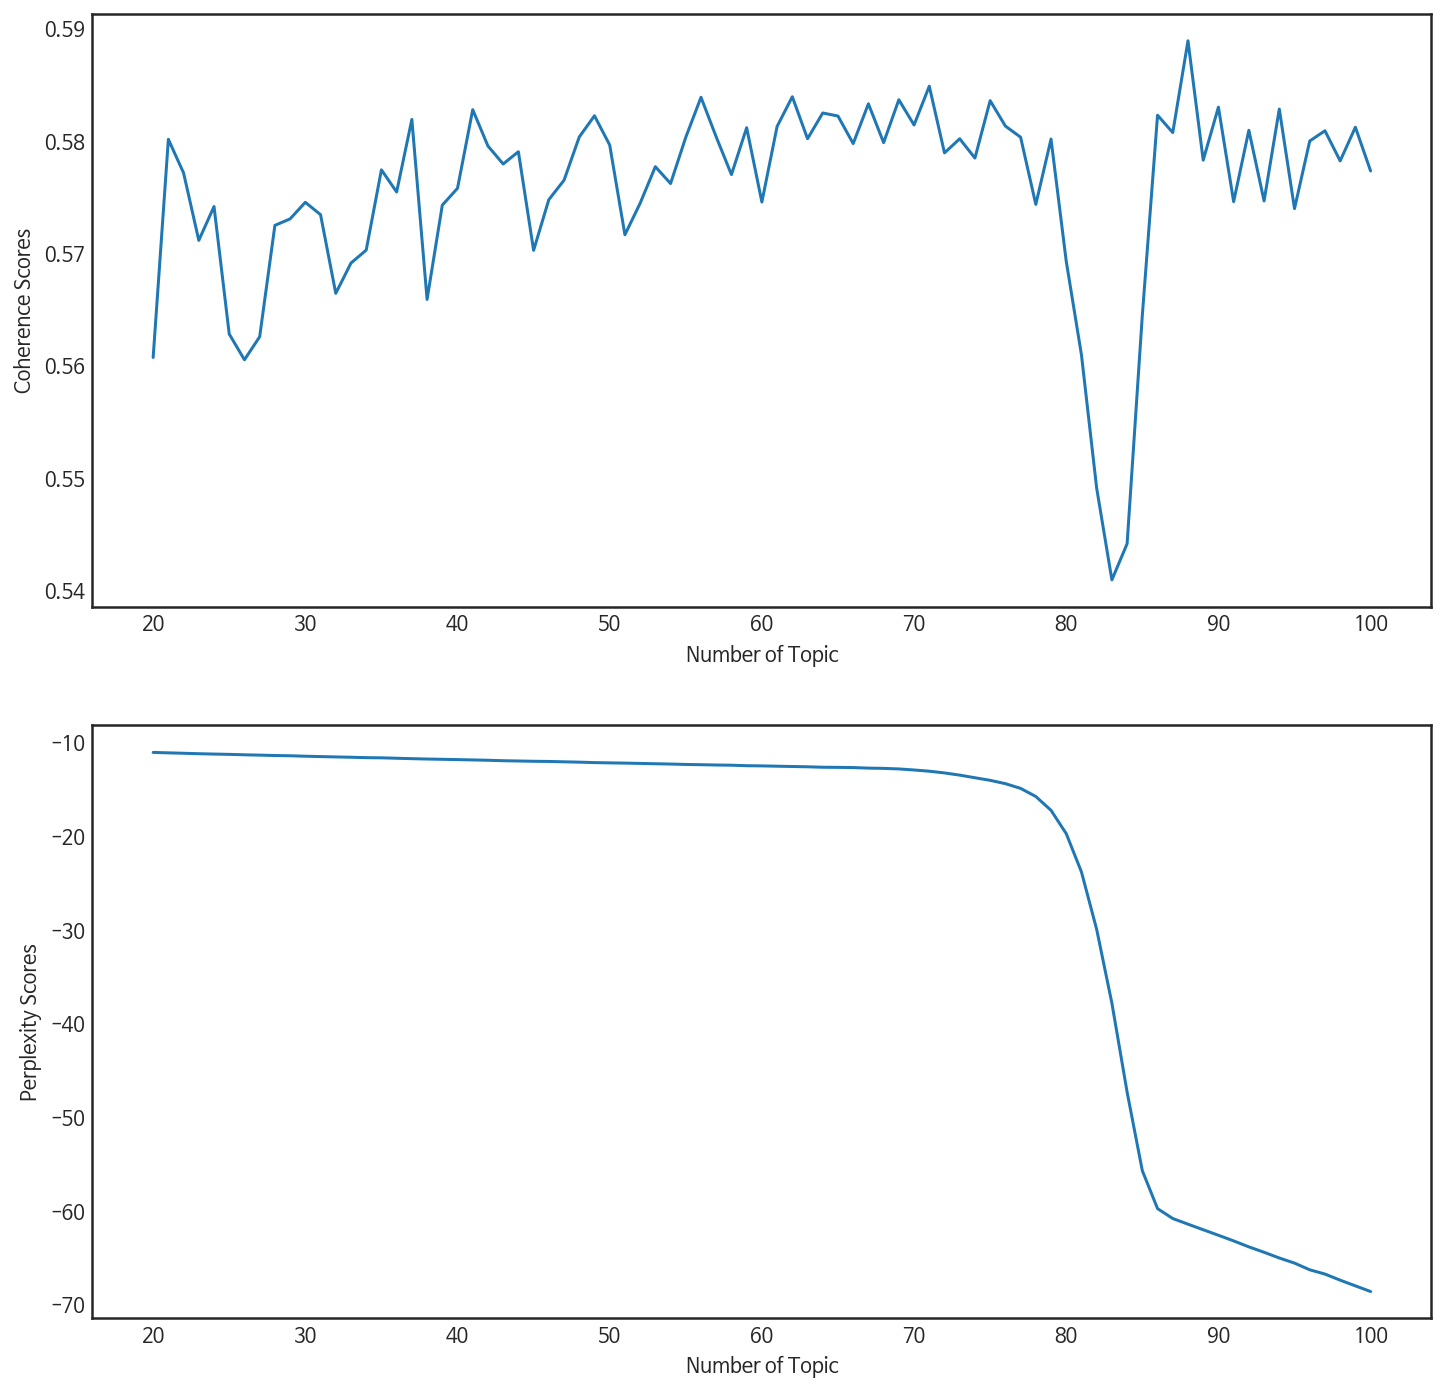

In [ ]:
x = [int(i) for i in range(min_topics, max_topics)]

plt.subplot(2,1,1)
plt.plot(x, coherences_score)
plt.xlabel('Number of Topic')
plt.ylabel('Coherence Scores')

plt.subplot(2,1,2)
plt.plot(x, perplexities_score)
plt.xlabel('Number of Topic')
plt.ylabel('Perplexity Scores')
plt.show();

#### LDA 시각화

In [ ]:
lda_model_88 = LdaModel(corpus, num_topics=88, id2word=dictionary, passes=1)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_88 = pyLDAvis.gensim.prepare(lda_model_88, corpus, dictionary)
pyLDAvis.display(vis_88)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# 저장
# pyLDAvis.save_html(vis_88, '연예 뉴스_lda(88).html')

# 2 특정 키워드 분석

In [128]:
keyword = '차'
keywords = ['반도체','배터리','수소','차','자동차']

In [129]:
# keywords = list(input().split(' '))

## 2-1 사회 연결망 분석 (Social Network Analysis)

### 동시 출현 단어

#### Bigram

In [130]:
bgrams = [bigrams(x) for x in df['noun'].tolist()]

token = []
for idx, i in enumerate(bgrams) :
  try : 
    token += ([x for x in i])
  except :   # 공백 리스트 예외 처리
    pass
    # print(f'{idx} : {list(i)}')
# token

cfd = ConditionalFreqDist(token)
# cfd.conditions()

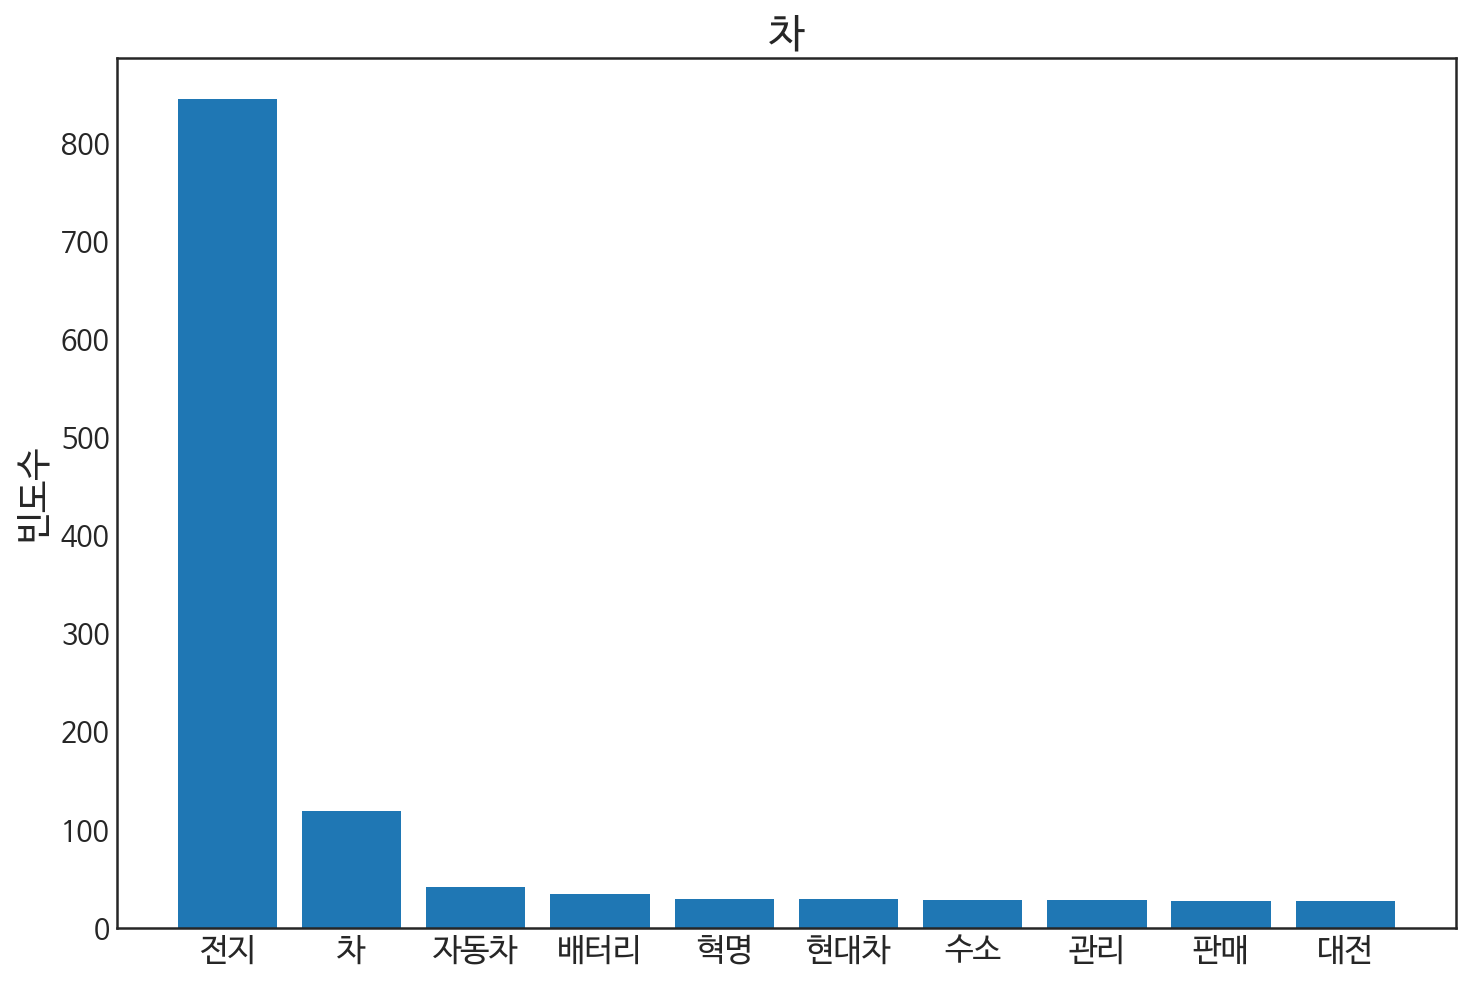

In [131]:
plt.figure(figsize=(12,8))
x = [i[0] for i in cfd[keyword].most_common(10)]
y = [i[1] for i in cfd[keyword].most_common(10)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('빈도수', fontsize=18)
plt.show()

In [132]:
# keyword = '공개'
print(cfd[keyword].most_common(10))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   print(idx, keyword, cfd[keyword].most_common(10))

[('전지', 844), ('차', 119), ('자동차', 41), ('배터리', 34), ('혁명', 29), ('현대차', 29), ('수소', 28), ('관리', 28), ('판매', 27), ('대전', 27)]


#### Trigram

In [133]:
# trigram
tgrams = [ngrams(x,3) for x in df['noun'].tolist()]
ttoken = []

for idx, i in enumerate(tgrams) :
  try : 
    ttoken += ([x for x in i])
  except :
    pass
#     print(f'{idx} : {list(i)}')
# ttoken

condition_pairs = ((w0, (w1, w2)) for w0, w1, w2 in ttoken)
cfd_trigrams = ConditionalFreqDist(condition_pairs)

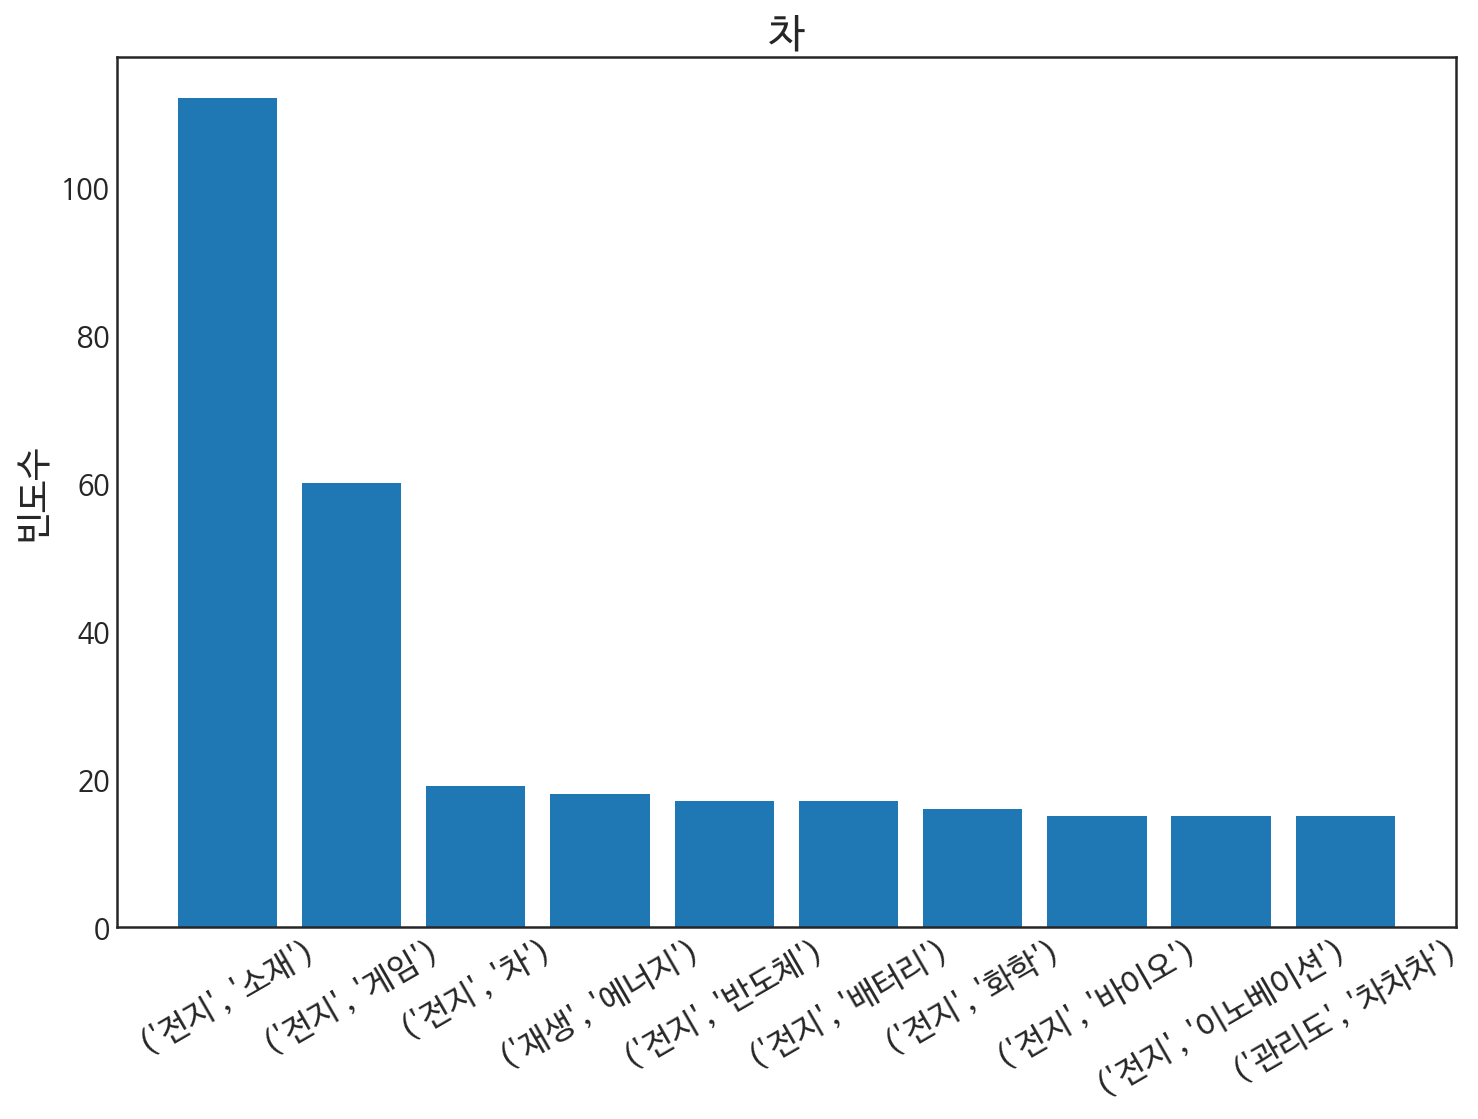

In [134]:
plt.figure(figsize=(12,8))
x = [str(i[0]) for i in cfd_trigrams[keyword].most_common(10)]
y = [i[1] for i in cfd_trigrams[keyword].most_common(10)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=14)
plt.ylabel('빈도수', fontsize=18)
plt.show()

In [135]:
# keyword = '공개'
print(cfd_trigrams[keyword].most_common(10))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   print(idx, keyword, cfd_trigrams[keyword].most_common(10))

[(('전지', '소재'), 112), (('전지', '게임'), 60), (('전지', '차'), 19), (('재생', '에너지'), 18), (('전지', '반도체'), 17), (('전지', '배터리'), 17), (('전지', '화학'), 16), (('전지', '바이오'), 15), (('전지', '이노베이션'), 15), (('관리도', '차차차'), 15)]



### 단어 유사도 (Word2Vec)
- https://radimrehurek.com/gensim/models/word2vec.html
- https://hoonzi-text.tistory.com/2

In [136]:
w2v = Word2Vec(sentences=df['noun'].tolist(), size=200, window=5, min_count=4, workers=4, sg=0)
# workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

# w2v.wv.vocab.keys()
w2v.wv.vectors.shape

(16221, 200)

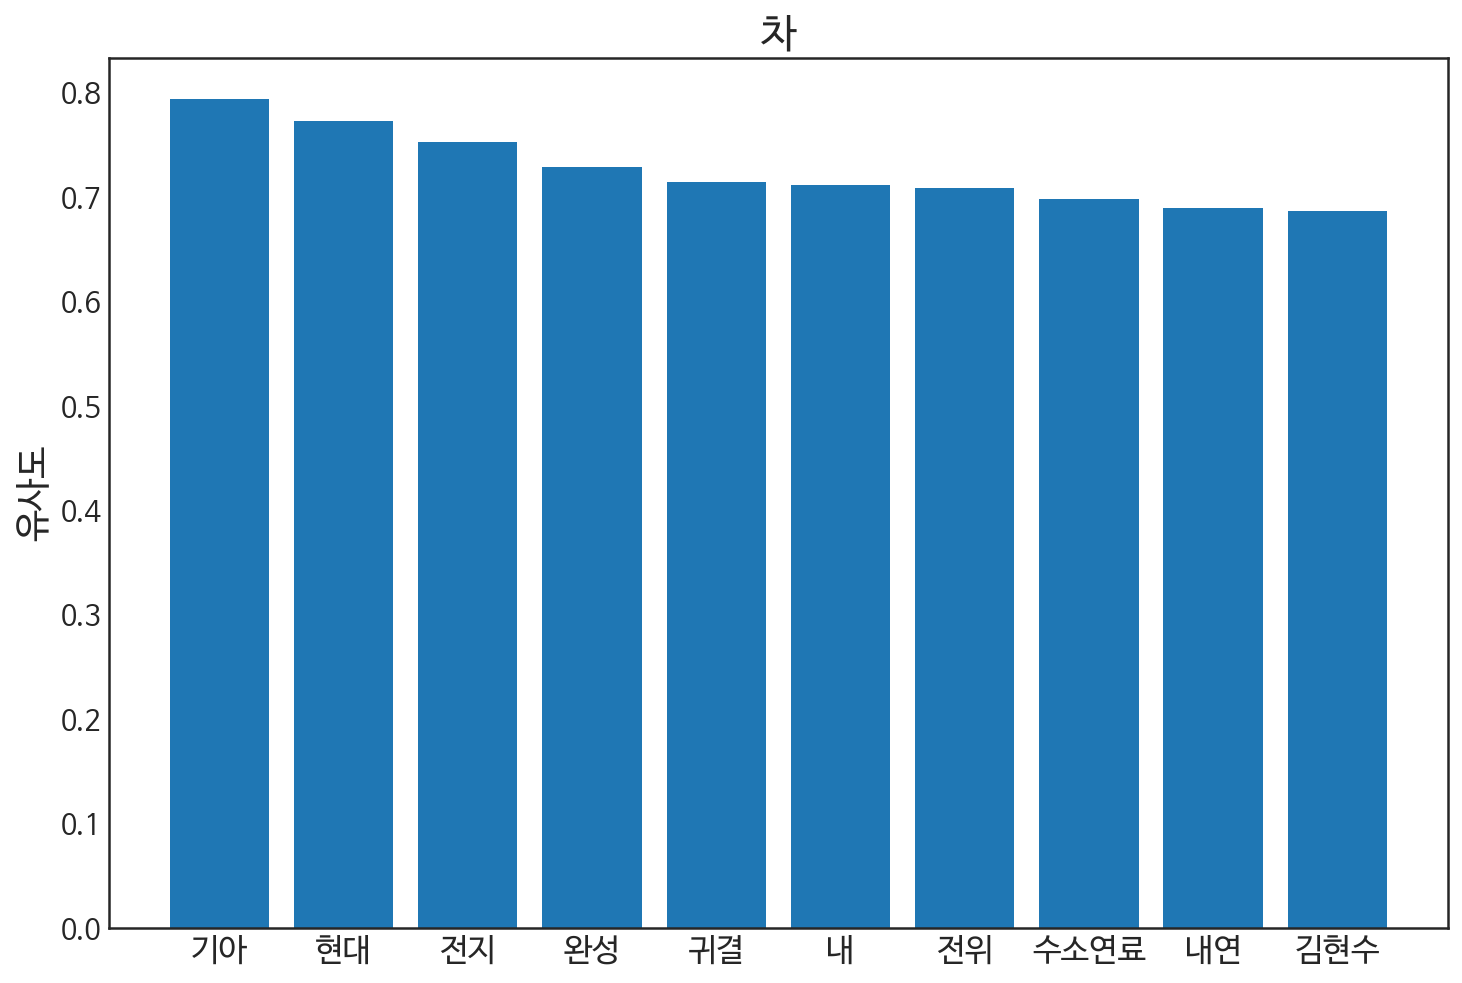

In [137]:
plt.figure(figsize=(12,8))
x = [i[0] for i in w2v.wv.most_similar(keyword)]
y = [i[1] for i in w2v.wv.most_similar(keyword)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('유사도', fontsize=18)
plt.show()

In [138]:
# keyword = '공개'
print(w2v.wv.most_similar(keyword, topn=20))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   try : print(idx, keyword, w2v.wv.most_similar(keyword, topn=20))
#   except : print(idx, keyword, '없음')

[('기아', 0.7932735681533813), ('현대', 0.7724014520645142), ('전지', 0.7523829936981201), ('완성', 0.7282015085220337), ('귀결', 0.7142547369003296), ('내', 0.7107325792312622), ('전위', 0.7082008123397827), ('수소연료', 0.6980055570602417), ('내연', 0.6891173124313354), ('김현수', 0.6865612864494324), ('동화', 0.6735621690750122), ('중고차', 0.6684892177581787), ('중량', 0.6680365800857544), ('의기', 0.6678962111473083), ('엔진', 0.66457599401474), ('장단기', 0.6604933738708496), ('치', 0.6551201343536377), ('카버', 0.6538608074188232), ('네델란드', 0.6531957387924194), ('아이온', 0.652678370475769)]


#### 시각화
- https://projector.tensorflow.org/

In [139]:
# from gensim.models import KeyedVectors  
# w2v.wv.save_word2vec_format('w2v')   # 모델 저장

In [140]:
# !python -m gensim.scripts.word2vec2tensor --input w2v --output w2v   # 쥬피터에서 실행

In [141]:
# Image('/content/drive/MyDrive/3조_final_project/02_연예 뉴스/EmbeddingProjector_방탄소년단.png')

## 2-2 시계열 분석 (Time Series Analysis)

In [142]:
a = [1,2,3,4,5,1,1,1]
a.count(1)

4

In [143]:
# 전체
df_time = df[['date','noun']]
df_time['count'] = df_time['noun'].apply(lambda x : x.count(keyword) if keyword in x else 0)
df_time = df_time.groupby('date').sum()
df_time['ratio'] = df_time['count'] / df_time['count'].sum() *100

### 빈도수 시각화

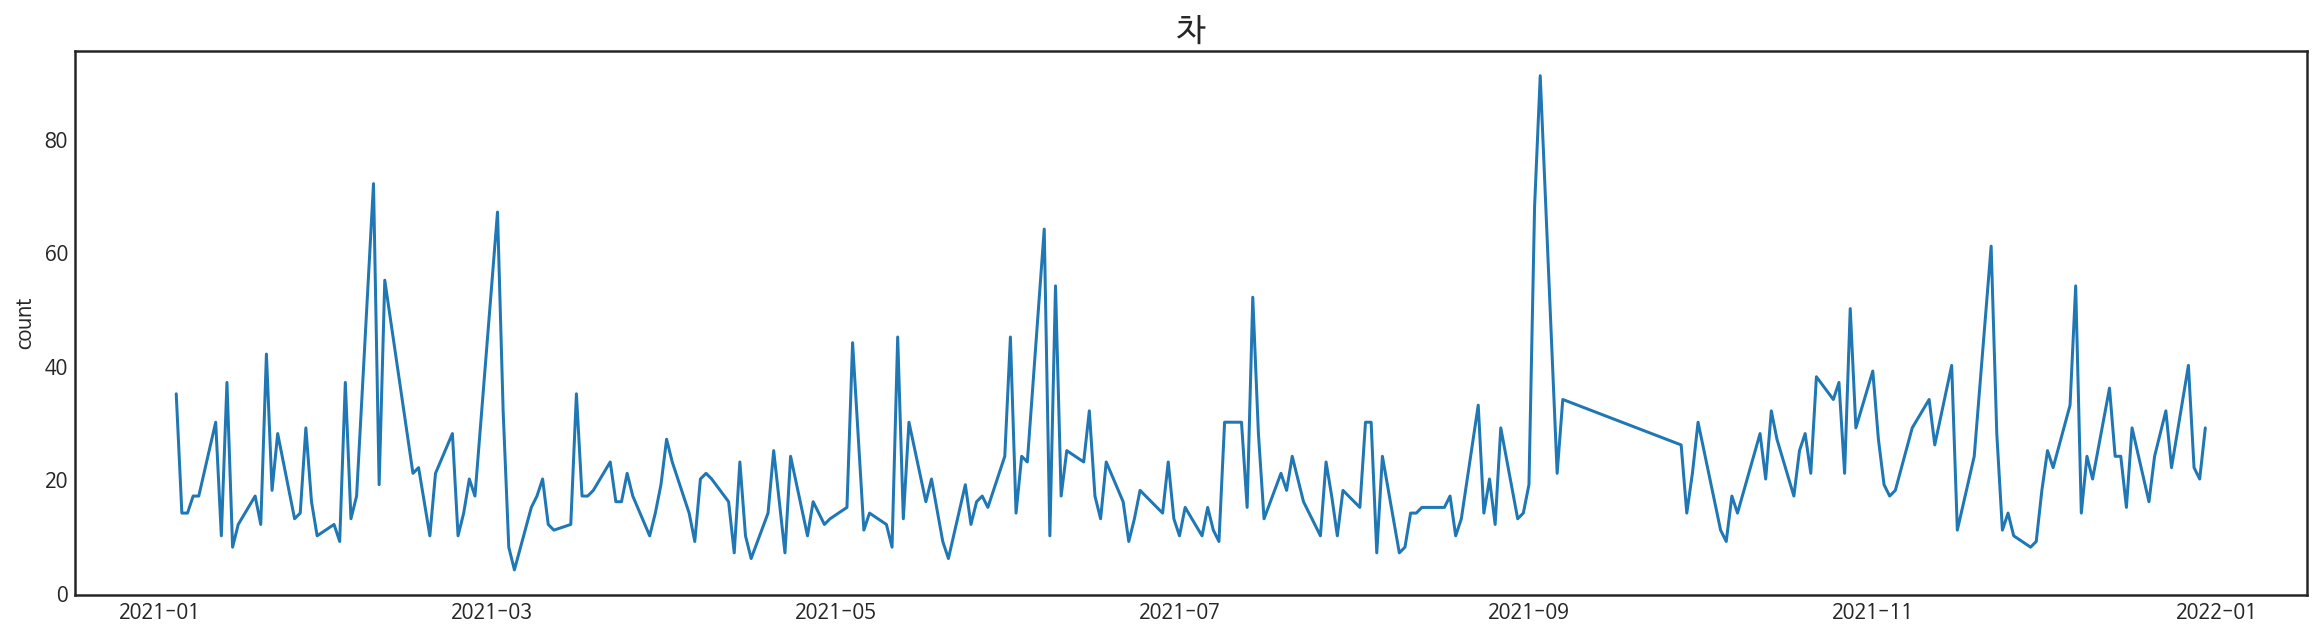

In [144]:
fig = plt.figure(figsize=(20,5))
plt.plot(df_time['count'])
plt.title(keyword, fontsize=16)
plt.ylabel('count')
plt.show()

### 분해 시계열

In [145]:
# 시계열 분해 (전체)
decompostion = sm.tsa.seasonal_decompose(df_time['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

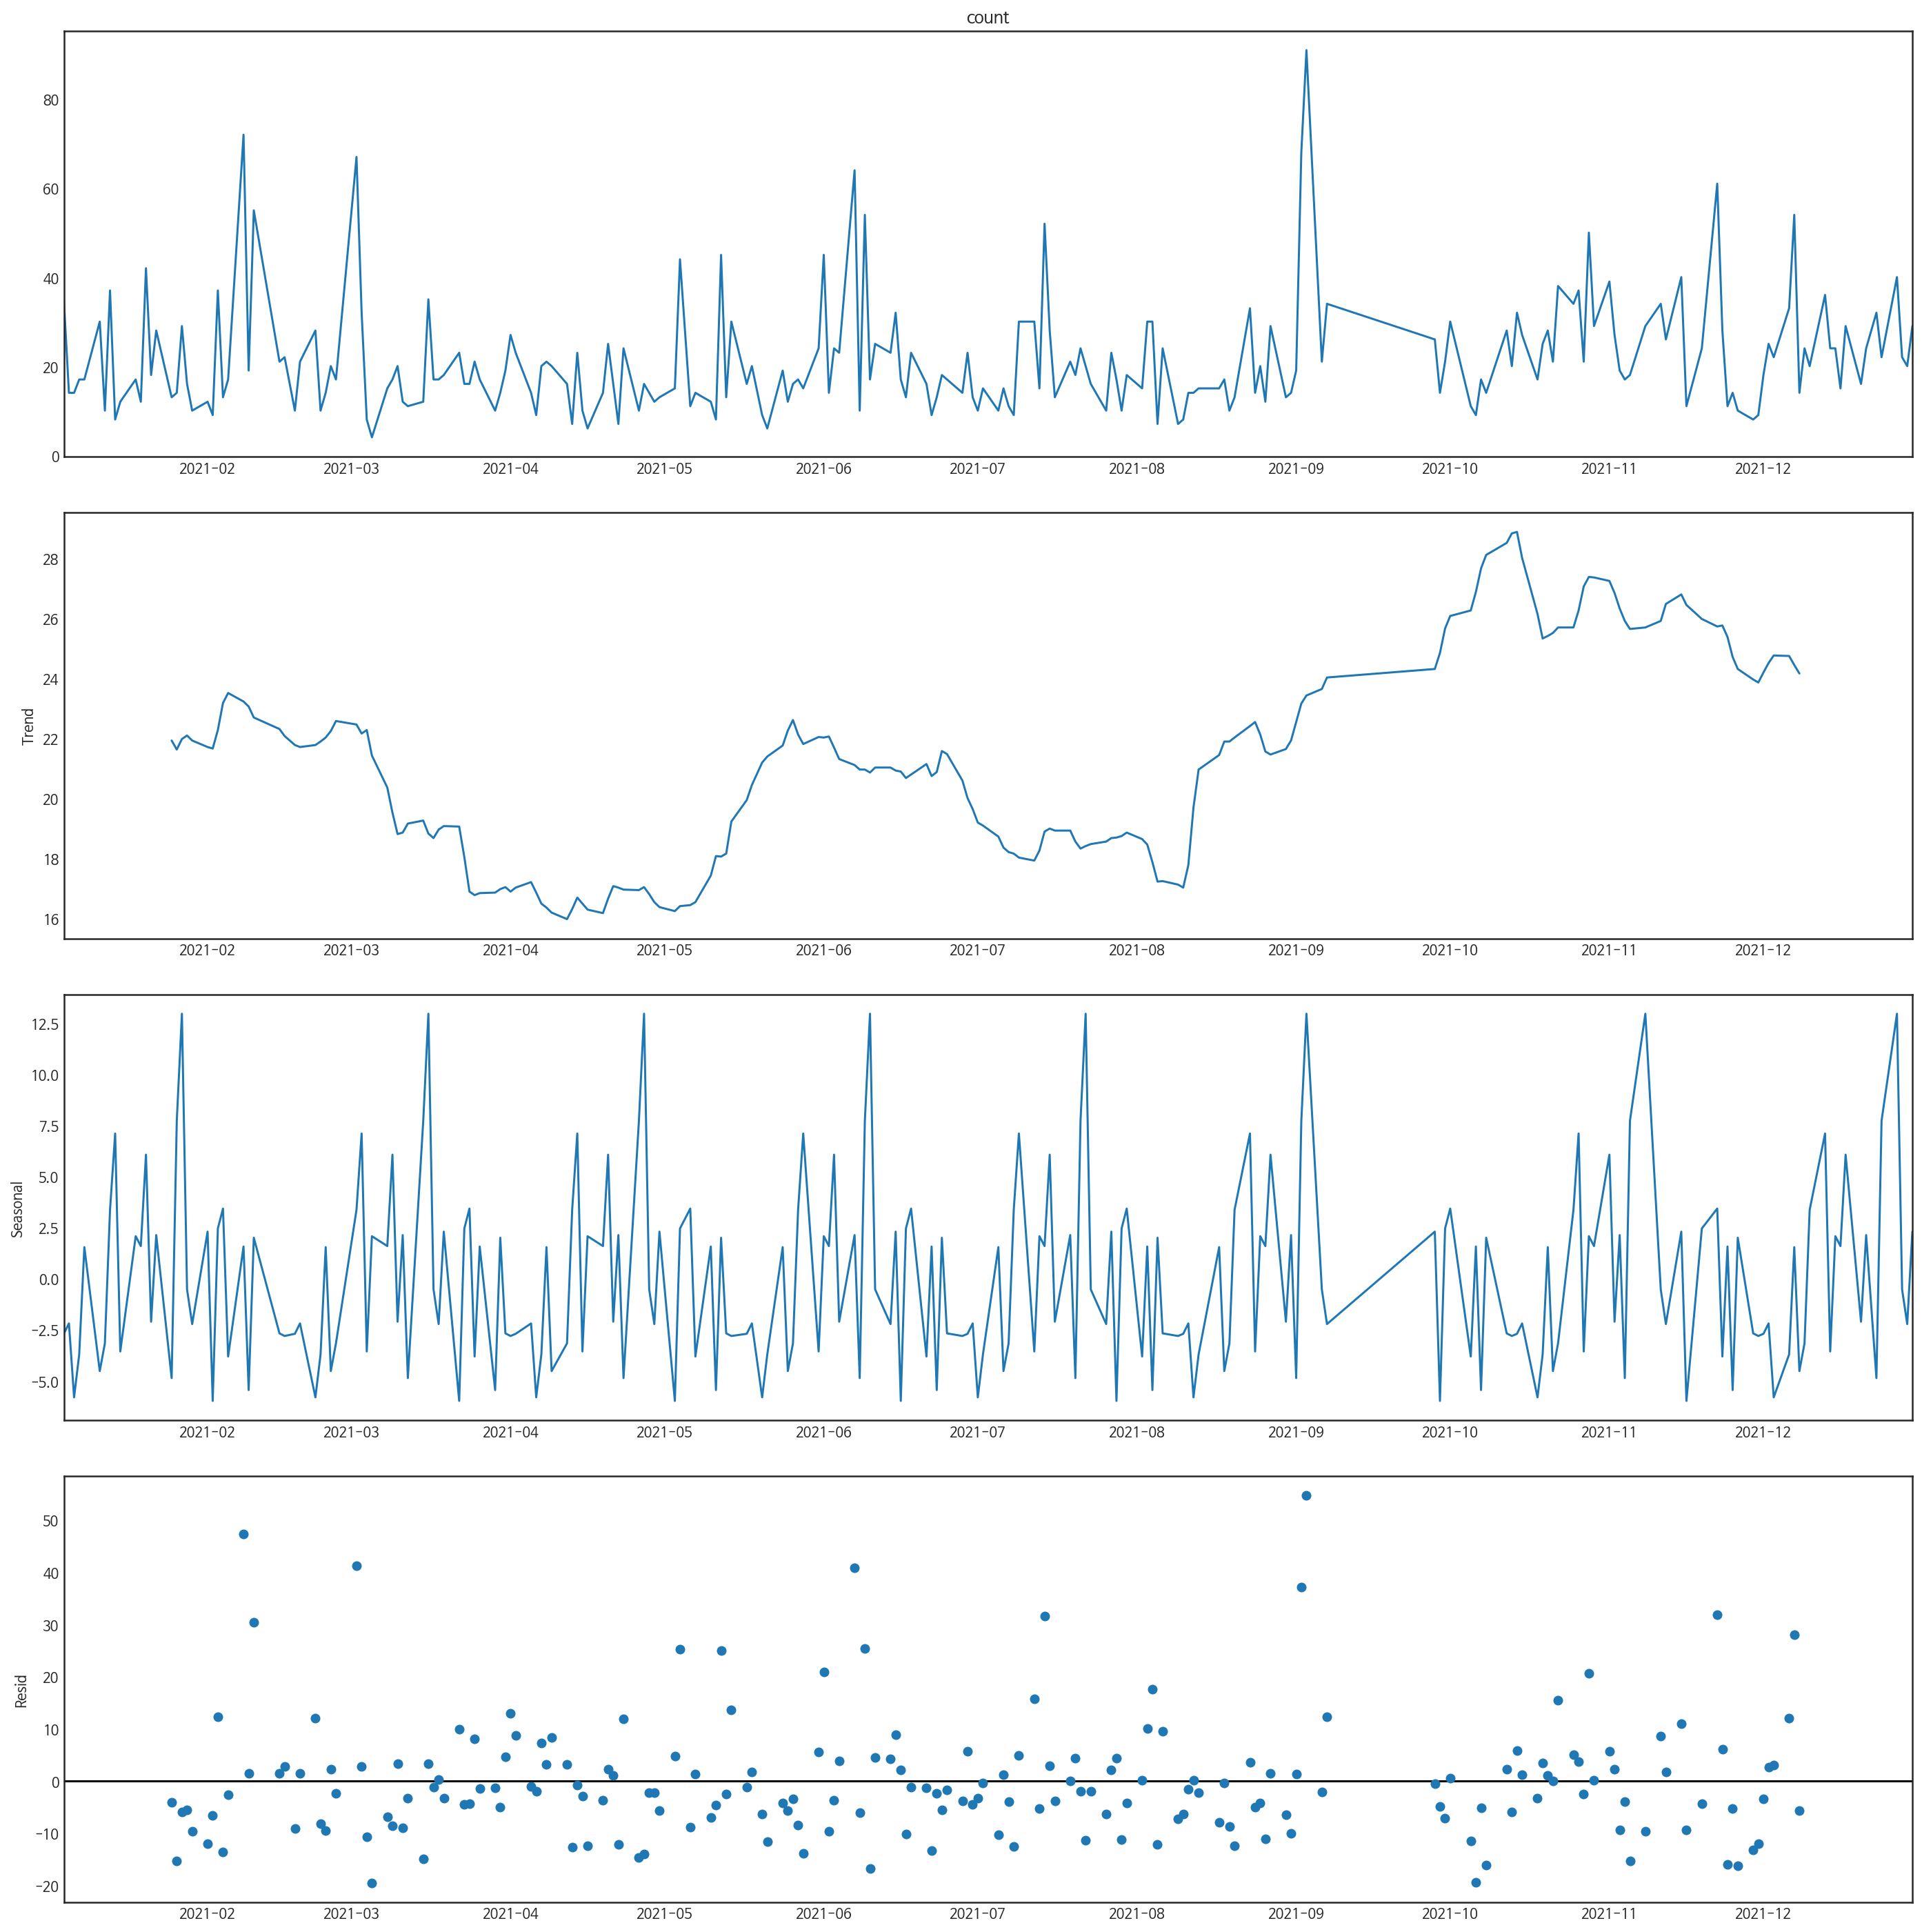

In [146]:
fig = decompostion.plot()
fig.set_size_inches(20,20)
plt.show()

### 비교 분석

In [147]:
# keywords = list(input().split(' '))

for keyword in keywords :
  globals()['df_time_{}'.format(keyword)] = df[['date','noun']]
  globals()['df_time_{}'.format(keyword)]['count'] = globals()['df_time_{}'.format(keyword)]['noun'].apply(lambda x : x.count(keyword) if keyword in x else 0)
  globals()['df_time_{}'.format(keyword)] = globals()['df_time_{}'.format(keyword)].groupby('date').sum()
  if globals()['df_time_{}'.format(keyword)]['count'].sum() == 0 :
    globals()['df_time_{}'.format(keyword)]['ratio'] = 0
  else :
    globals()['df_time_{}'.format(keyword)]['ratio'] = globals()['df_time_{}'.format(keyword)]['count'] / globals()['df_time_{}'.format(keyword)]['count'].sum() *100

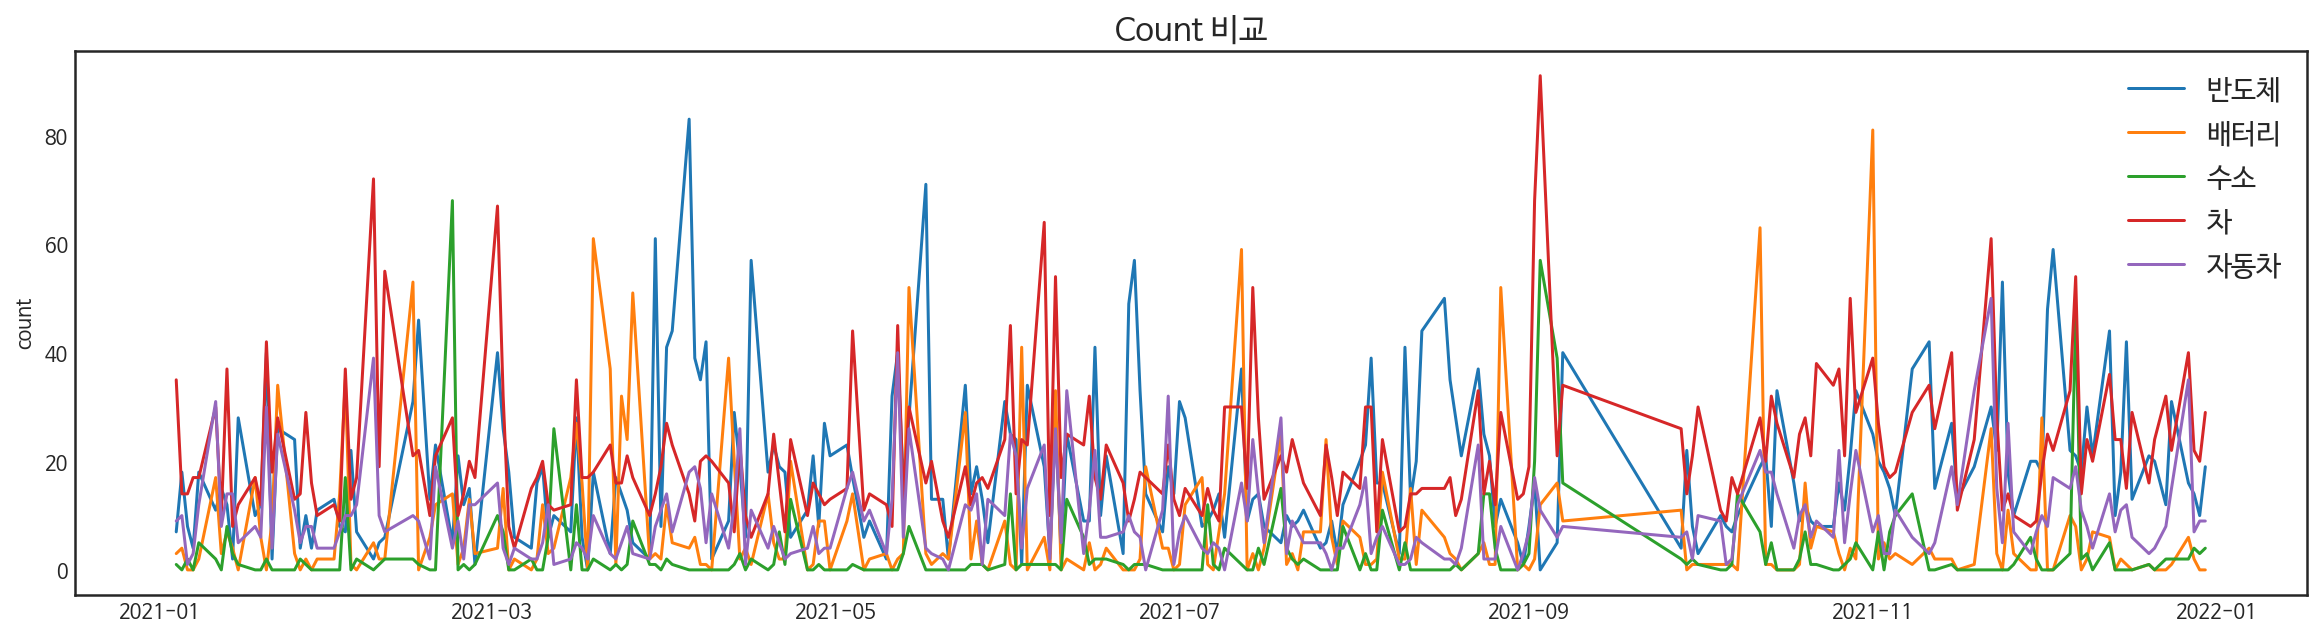

In [148]:
fig = plt.figure(figsize=(20,5))
for keyword in keywords :
  plt.plot(globals()['df_time_{}'.format(keyword)]['count'], label=keyword)
  plt.title('Count 비교', fontsize=16)
  plt.legend(fontsize=14)
  plt.ylabel('count')
plt.show()

In [149]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

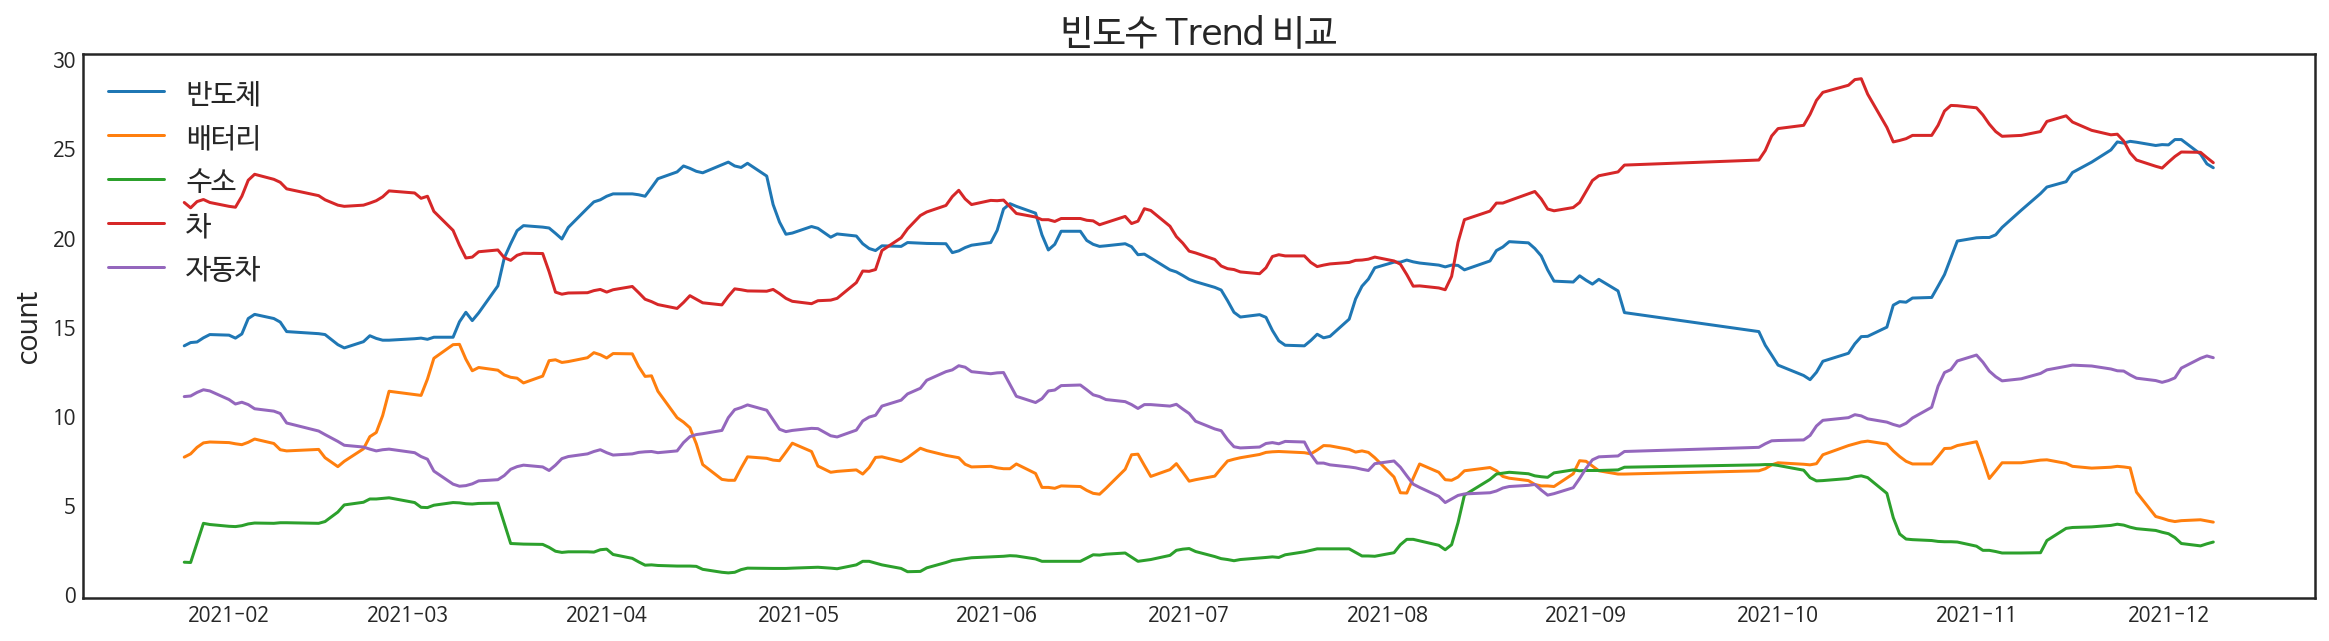

In [150]:
fig = plt.figure(figsize=(20,5))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('빈도수 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('count', fontsize=14)
plt.show()

In [151]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['ratio'], model='additive', period=30)   # model{“additive”, “multiplicative”}

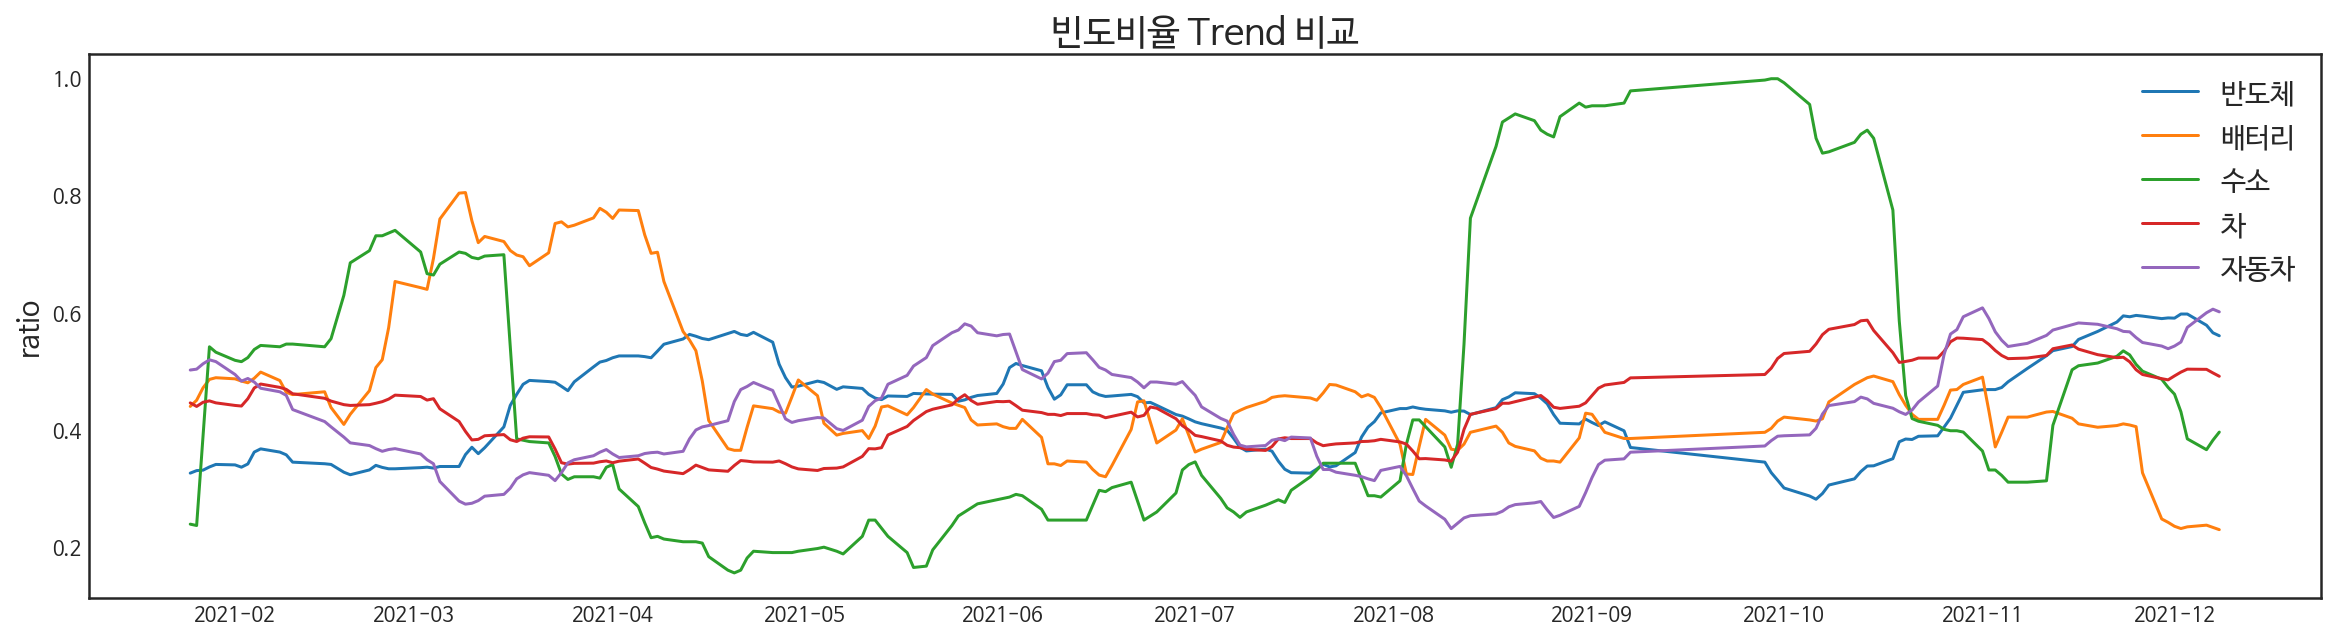

In [152]:
fig = plt.figure(figsize=(20,5))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('빈도비율 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('ratio', fontsize=14)
plt.show()